In [2]:
import pandas as pd
import numpy as np
import math
import fbprophet
import matplotlib.pyplot as plt
from pandas import DataFrame

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima

from tbats import TBATS, BATS

from keras import backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.
C:\Users\Joseph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Joseph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Joseph\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\

First load the dataset. We want to look at the number of riders each day that went from Berkeley to Downtown San Francisco (any of Embarcadero, Montgomery, Powell, and Civic Center stations). The goal is to analyze the time series for trends, seasonality, etc., and evaluate several models (such as ARIMA and TBATS) for the series and use it for forecasting. We will then use a LSTM recurrent neural network to forecast as well.

In [3]:
airline = pd.read_csv("airline-passengers.csv")
df16 = pd.read_csv("date-hour-soo-dest-2016.csv.gz", names=('Date', 'Hour', 'Origin','Destination', 'Riders'))
df17 = pd.read_csv("date-hour-soo-dest-2017.csv.gz", names=('Date', 'Hour', 'Origin','Destination', 'Riders'))
df18 = pd.read_csv("date-hour-soo-dest-2018.csv.gz", names=('Date', 'Hour', 'Origin','Destination', 'Riders'))
df19 = pd.read_csv("date-hour-soo-dest-2019.csv.gz", names=('Date', 'Hour', 'Origin','Destination', 'Riders'))

In [4]:
bart0 = [df16, df17, df18]
bart0 = pd.concat(bart0)

In [73]:
bart1 = bart0.loc[(bart0['Origin'] == 'DBRK') & (bart0['Destination'].isin(['EMBR', 'MONT', 'POWL', 'CIVC']))]
bart = bart1.groupby(['Date']).sum()
bart.reset_index(level=0, inplace = True)
test0 = df19.loc[(df19['Origin'] == 'DBRK') & (df19['Destination'].isin(['EMBR', 'MONT', 'POWL', 'CIVC']))]
test1 = test0.groupby(['Date']).sum()
test = np.array(test1['Riders'])

,Hour,Riders
Date,,
2019-01-01,911,530
2019-01-02,1068,1865
2019-01-03,1072,2161
2019-01-04,1068,2128
2019-01-05,1037,851
2019-01-06,926,489
2019-01-07,1068,2299
2019-01-08,1063,2561
2019-01-09,1045,2646


### Analysis

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Joseph\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step 1/4 finished. Error for FB Prophet prediction: 1776.7112570590039


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step 2/4 finished. Error for FB Prophet prediction: 1853.635207197327


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step 3/4 finished. Error for FB Prophet prediction: 642.7720111757685
Step 4/4 finished. Error for FB Prophet prediction: -383.1916297951061


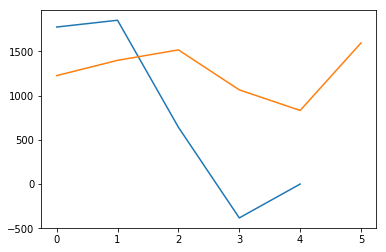

In [80]:
# utils

def diff(series, d, D=0, m=1):
    """
    series: np array
    d, D, m: postive integers
    Returns the d-order differencing, plus a D-order seasonal (length-m) difference
    """
    result = series
    while d > 0:
        result = result[1:] - result[:-1]
        d -= 1
    while D > 0:
        result = result[m:] - result[:-m]
        D -= 1
    return result

def mv_avg(series, k):
    """
    series: np array
    k: postive integer
    Returns the moving average time series, using window size of k.
    """
    result = np.zeros(len(series))
    for i in range(len(series)):
        result[i] = np.mean(series[max(0,i-k): min(len(series),i+k+1)])
    return result

def mv_sd(series, k):
    """
    series: np array
    k: postive integer
    Returns the moving standard deviation time series, using window size of k.
    """
    result = np.zeros(len(series))
    for i in range(len(series)):
        result[i] = np.std(series[max(0,i-k): min(len(series),i+k+1)])
    return result

def rmse(u, v):
    """Computes the Root Mean Square Error between the two vectors u and v"""
    return np.sqrt(np.mean((u - v) ** 2))

def plot_sarima_forecast(fitted_model, start_, end_, plot_start, endog, exog, model_name):
    """
    Using a fitted SARIMA model, makes a forecast from start_ to end_ and plots it.
    endog is a np.array of the time series, and exog is the np.array of the associated
    exogenous variables.
    Also prints out the root mean square error for the model
    """
    predictions = fitted_model.predict(start=start_, end=end_-1, exog=exog)
    forecast = fitted_model.get_forecast(steps=end_-start_, exog=exog)
    plt.figure(figsize=(16,6))
    lower = forecast.conf_int()[:, 0]
    upper = forecast.conf_int()[:, 1]
    plt.fill_between(np.arange(start_, end_), lower, upper, alpha=0.1)
    plt.plot(np.arange(plot_start, end_), endog)
    plt.plot(np.arange(start_, end_), predictions)
    plt.title("Forecast Results")
    plt.legend(labels=("True Data", "Forecast"))
    print("Root Mean Square Error Result for {0} forecast: {1}".format(model_name, rmse(predictions, endog)))

def ts_cv(model_type, data, start, sarima=None, prophet_param=0.05):
    """
    model_type -- String specifying the type of model. Must be 'sarima', 'prophet', or 'nn' (more info below)
    data -- time series data, type depends on model_type
    start -- index specifying where to start the cross validation
    sarima -- If model_type is sarima, then sarima field is tuple (p,d,q,P,D,Q,M), to fit SARIMA(p,d,q)x(P,D,Q,m)
    prophet_param -- Changepoint prior scale parameter for prophet model
    
    Performs time-series cross validation, and returns the CV-statistic which is the RMSE of all errors
    of all fitted models.
    *** If model_type is prophet, then data must be in the correct format
    *** If model_type is nn, then data will automatically be scaled here
    """
    scores = np.zeros(len(data) - start)
    if model_type == 'sarima':
        for t in range(start, len(data)-1):
            p, d, q = sarima[0], sarima[1], sarima[2]
            P, D, Q, m = sarima[3], sarima[4], sarima[5], sarima[6]
            model = SARIMAX(endog=data[:t], order=(p,d,q), seasonal_order=(P,D,Q,m))
            results = model.fit()
            predictions = results.predict(start=t, end=t)
            scores[t-start] = rmse(predictions[0], data[t])
            print("Step {0}/{1} finished. Error for SARIMA prediction: {2}".format(t-start+1, len(data)-start-1, scores[t-start]))
    elif model_type == 'prophet':
        for t in range(start, len(data)-1):
            prophet = fbprophet.Prophet(changepoint_prior_scale=prophet_param)
            prophet.fit(data[:t])
            fc = prophet.make_future_dataframe(periods=1, freq='D')
            fc = prophet.predict(fc).yhat
            fc = fc[len(fc)-1]
            scores[t-start] = fc
            #scores[t-start] = rmse(fc, data.loc[t, 'y'])
            print("Step {0}/{1} finished. Error for FB Prophet prediction: {2}".format(t-start+1, len(data)-start-1, scores[t-start]))
    
    plt.plot(scores)
    plt.plot(series[len(series)-6:])
    #return np.mean(scores)

ts_cv('prophet', bart_pro, len(series)-5)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Joseph\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


ds                            2016-01-01 00:00:00
trend                                     2560.02
yhat_lower                               -577.777
yhat_upper                                520.183
trend_lower                               2560.02
trend_upper                               2560.02
additive_terms                           -2976.67
additive_terms_lower                     -2976.67
additive_terms_upper                     -2976.67
weekly                                    -1461.2
weekly_lower                              -1461.2
weekly_upper                              -1461.2
yearly                                   -1515.74
yearly_lower                             -1515.74
yearly_upper                             -1515.74
multiplicative_terms                            0
multiplicative_terms_lower                      0
multiplicative_terms_upper                      0
yhat                                     -33.8823
dtype: object


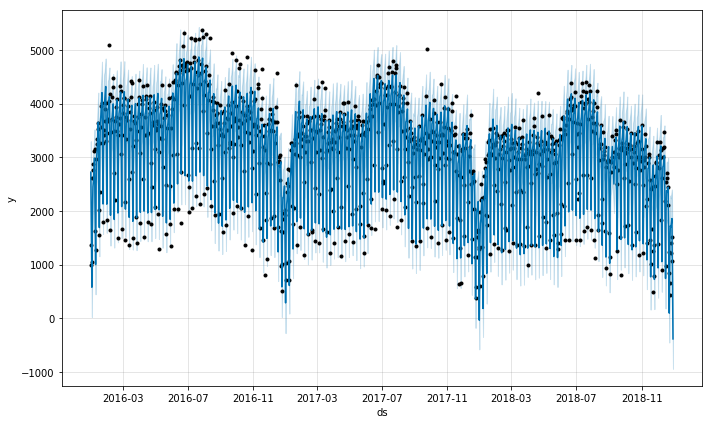

In [92]:
prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
prophet.fit(bart_pro[:len(series)-2])
fc = prophet.make_future_dataframe(periods=1, freq='D')
fc = prophet.predict(fc)
fig = plt.figure(figsize=(16,6))
fig = prophet.plot(fc)
print(np.min(fc[:-2]))

First, we plot the raw time series.

We see that there is a main slightly downward trend, in addition to a weekly seasonal cycle. A closer inspection of the data shows that Sundays have the fewest riders in any given week, and ridership tends to increase every day Monday through Friday, until Saturday, when ridership decreases, along with the following Sunday. Furthermore, by looking at a moving average (we looked at a centered moving average with a window size of 7), we also notice a yearly seasonal cycle. That is, throughout the year, there seems to be a long-term pattern, repeating every year. Immediately, we see two main events each year: the end/beginning (i.e. the holidays), and the summer months. We hypothesize that there is a yearly constant average of riders (which seems to decrease slightly each year), but it drops approaching the end of December (in fact, the days of lowest ridership are Christmas and New Years Day) and increasing to the yearly average throughout beginning-to-mid-January. Then, the number of riders increases in the summer months, most likely due to summer jobs/internships in San Francisco for many college students in Berkeley. As the academic year starts in late August, ridership decreases back to the yearly average.

Note that, visually, it seems that the variance is for the most part stable and constant throughout the time period, suggesting that we have homoscedasticity. An augmented Dickey-Fuller test gives a p-value suggesting that the time series is trend-stationary; however, by dividing the data by year, we see that the process is not stationary. This is most likely due to the weekly seasonal behavior and the fact that the mean is most definitely not constant throughout a given year.

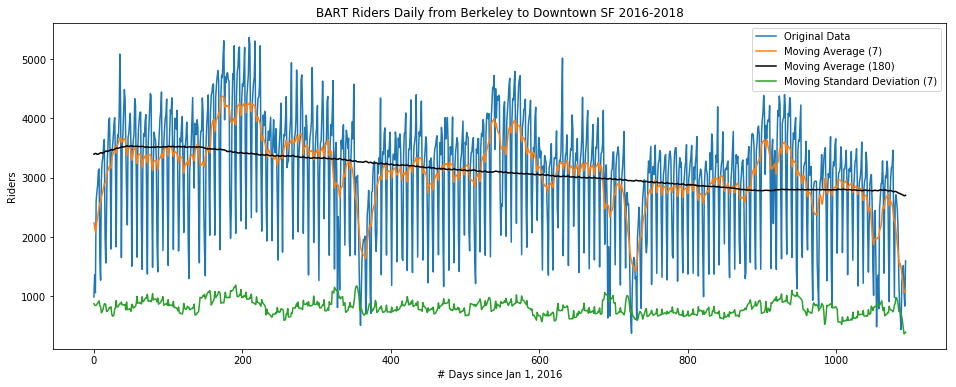

In [7]:
series = np.array(bart['Riders'])
plt.figure(figsize=(16,6))
plt.plot(series)
plt.plot(mv_avg(series, 7))
plt.plot(mv_avg(series, 180), color='black')
plt.plot(mv_sd(series, 7))
plt.xlabel('# Days since Jan 1, 2016')
plt.ylabel('Riders')
plt.legend(labels=('Original Data', 'Moving Average (7)', 'Moving Average (180)', 'Moving Standard Deviation (7)'))
plt.title('BART Riders Daily from Berkeley to Downtown SF 2016-2018')
plt.show()

In [8]:
def ad_results(series, p_val_only=False):
    test = adfuller(series)
    if not p_val_only:
        print('ADF Statistic: %f' % test[0])
        print('p-value: %f' % test[1])
        print('Critical Values:')
        for key, value in test[4].items():
            print('\t%s: %.3f' % (key, value))
    else:
        print('p-value: %f' % test[1])
        
print('Augmented Dickey-Fuller Test Results for whole data set:') 
ad_results(series)

print('Augmented Dickey-Fuller Test Results for 2016:')
ad_results(series[:365], p_val_only=True)

print('Augmented Dickey-Fuller Test Results for 2017:')
ad_results(series[365:730], p_val_only=True)

print('Augmented Dickey-Fuller Test Results for 2018:')
ad_results(series[730:], p_val_only=True)

Augmented Dickey-Fuller Test Results for whole data set:
ADF Statistic: -3.115451
p-value: 0.025431
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Augmented Dickey-Fuller Test Results for 2016:
p-value: 0.648086
Augmented Dickey-Fuller Test Results for 2017:
p-value: 0.506764
Augmented Dickey-Fuller Test Results for 2018:
p-value: 0.230696


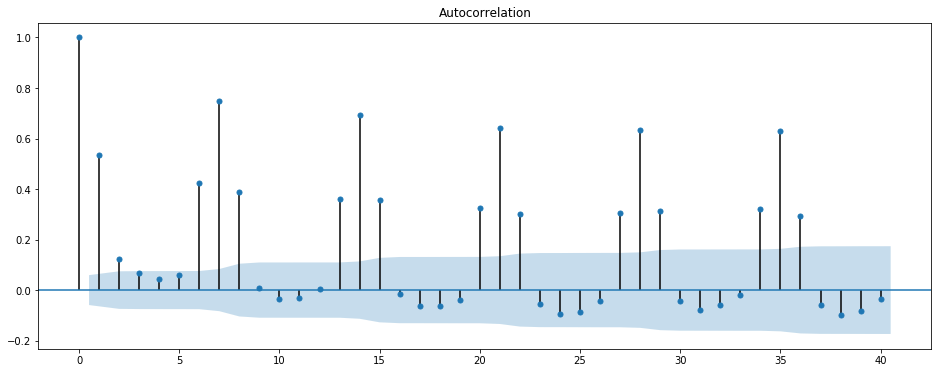

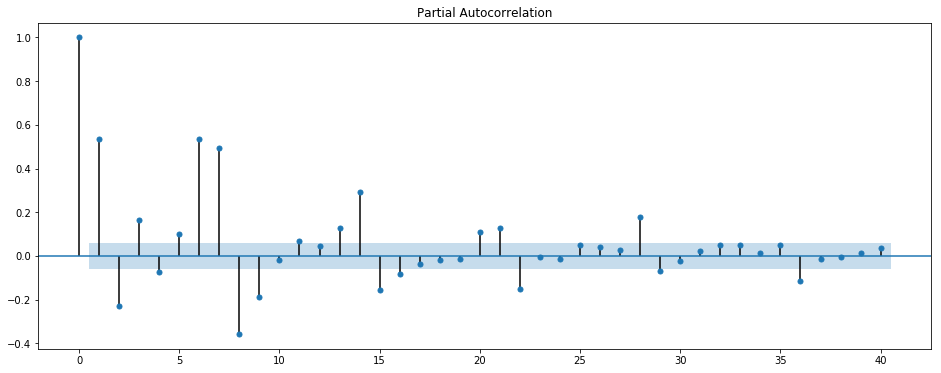

In [9]:
fig = plt.figure()
fig = plot_acf(series, lags=40);
fig.set_size_inches(16,6)

fig = plt.figure()
fig = plot_pacf(series, lags=40);
fig.set_size_inches(16,6)

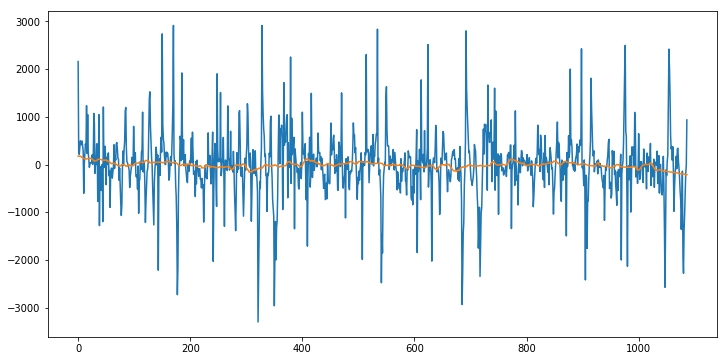

667.3520951752704
ADF Statistic: -9.412957
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [10]:
dseries = diff(series, 0, 1, 7)
plt.figure(figsize=(12,6))
plt.plot(dseries)
plt.plot(mv_avg(dseries, 50))
plt.show()

print(np.std(dseries))
ad_results(dseries)

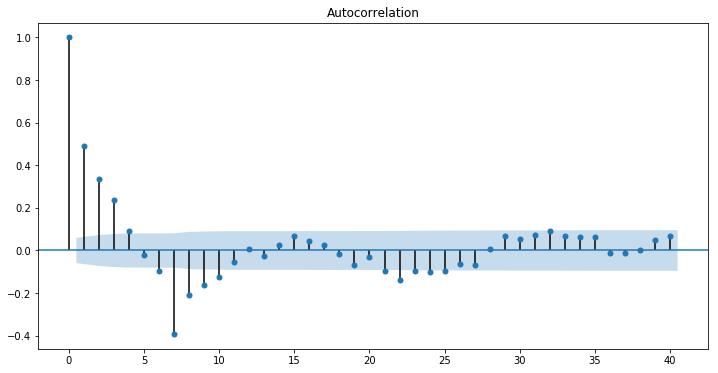

In [11]:
fig = plt.figure()
fig = plot_acf(dseries, lags=40)
fig.set_size_inches(12, 6)

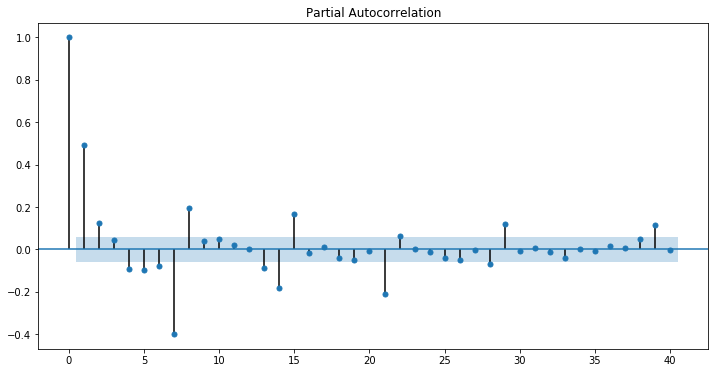

In [12]:
fig = plt.figure()
fig = plot_pacf(dseries, lags=40)
fig.set_size_inches(12, 6)

Below is a trend-seasonal decomposition of the time series. As we can see, there are two seasonalities: weekly and yearly (there does not seem to be a monthly seasonality), so we do this for each season. However, there does not seem to be many samples over several more years, so the decomposition using a season of length 365 is not smooth, but it does reveal a linear, downward trend in the number of riders.

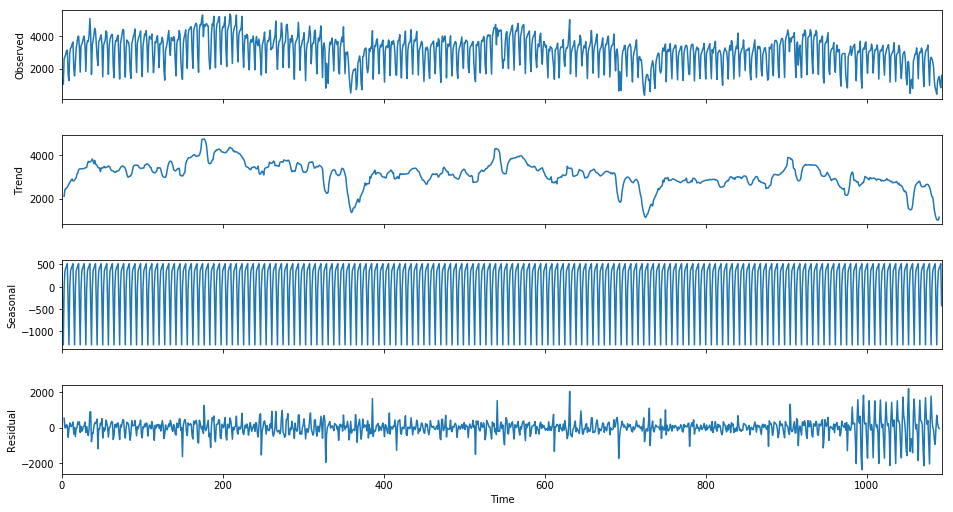

In [14]:
decomposition = seasonal_decompose(series, freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

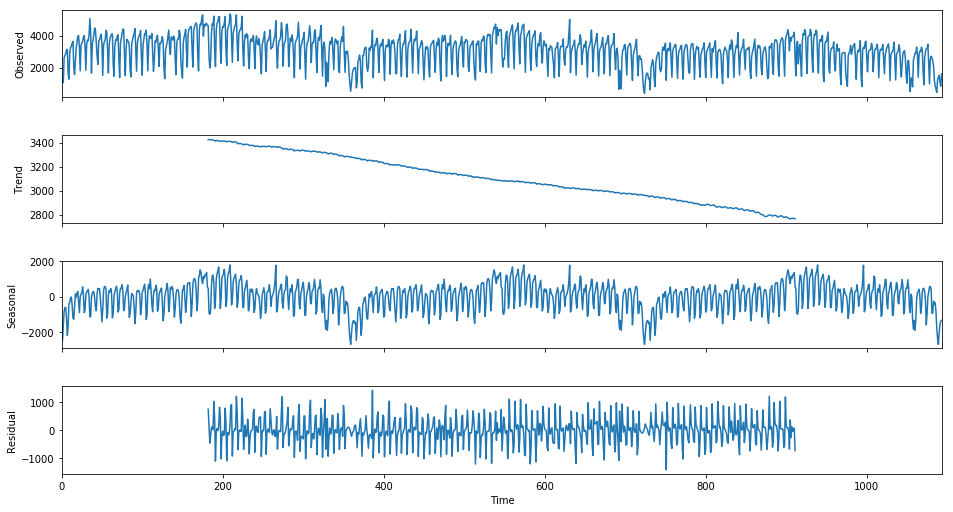

In [24]:
decomposition = seasonal_decompose(series, freq=365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [15]:
# Create array for exogenous variables for the predetermined dates
def make_exog(dataframe):
    external_vars = np.zeros([len(dataframe), 6])
    fixed_dates = ['01-01', '05-20', '08-25', '11-01', '12-01', '12-25']
    for i in range(len(fixed_dates)):
        for j in range(len(dataframe)):
            external_vars[j, i] = (bart['Date'][j][5:] == fixed_dates[i])
    return external_vars

train_exog = make_exog(bart)
test_exog = make_exog(test1)

We fit a SARIMA model using the common rules outlined in http://people.duke.edu/~rnau/arimrule.htm.

From the analysis above, we first fit a SARIMA$(2,0,4)\times(0,1,1)_7$ model. This is because the ACF tails off, becoming insignificant at a lag of about 4, while the PACF cuts off at a lag of about 2. Furthermore, we see that the autocorrelation at lag 7 is significantly negative, suggesting we add a SMA term to the model. Thus, we fit a SARIMA$(2,0,4)\times(0,1,1)_7$ model, which seems to be a good fit.

C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1094
Model:             SARIMAX(2, 0, 4)x(0, 1, 1, 7)   Log Likelihood               -8255.966
Date:                           Fri, 23 Aug 2019   AIC                          16539.933
Time:                                   13:23:58   BIC                          16609.809
Sample:                                        0   HQIC                         16566.383
                                          - 1094                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1399.1470    203.338     -6.881      0.000   -1797.682   -1000.612
x2          -228.0175    312.563     -0.730

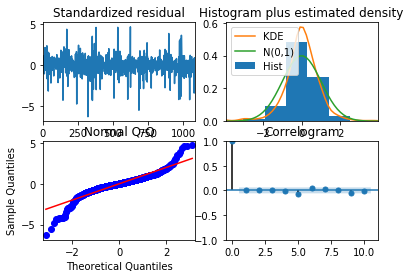

In [16]:
model = SARIMAX(endog=series, exog=train_exog, order=(2,0,4), seasonal_order=(0,1,1,7))
results = model.fit()
results.plot_diagnostics();
print(results.summary())

Root Mean Square Error Result for SARIMA(2,0,4)x(0,1,1,7) forecast: 332.9497484392896


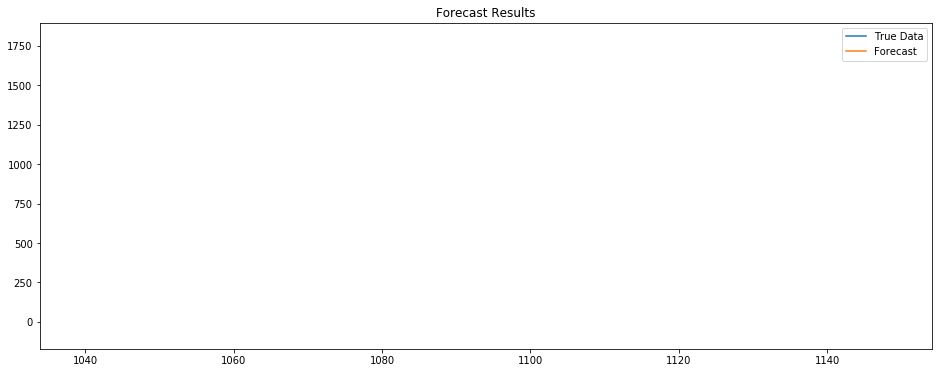

In [44]:
plot_sarima_forecast(results, len(series)+1, len(series)+len(test), len(series), test, test_exog, "SARIMA(2,0,4)x(0,1,1,7)")

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1094
Model:             SARIMAX(1, 0, 2)x(0, 1, 1, 7)   Log Likelihood               -8256.306
Date:                           Thu, 22 Aug 2019   AIC                          16534.613
Time:                                   11:45:38   BIC                          16589.516
Sample:                                        0   HQIC                         16555.395
                                          - 1094                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1399.1700    198.111     -7.063      0.000   -1787.460   -1010.881
x2          -227.9996    311.397     -0.732

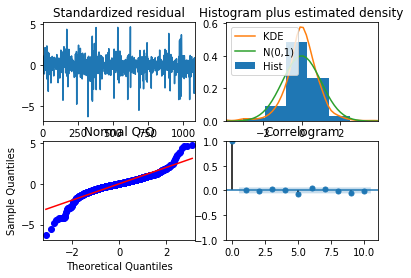

In [86]:
model = SARIMAX(endog=series, exog=train_exog, order=(1,0,2), seasonal_order=(0,1,1,7))
results = model.fit()
results.plot_diagnostics();
print(results.summary())

In [1]:
plot_sarima_forecast(results, len(series), len(series)+len(test), len(series), test, test_exog, "SARIMA(1,0,2)x(0,1,1,7)")

NameError: name 'plot_sarima_forecast' is not defined

In [88]:
auto_arima(series, max_p=3, max_q=3, max_P=1, max_Q=1, d=0, D=1, m=7, trace=True)

C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 7); AIC=16539.860, BIC=16579.789, Fit time=9.425 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=17226.985, BIC=17236.968, Fit time=0.072 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=16679.400, BIC=16699.365, Fit time=2.104 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=16681.344, BIC=16701.309, Fit time=2.892 seconds


C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 7); AIC=16529.861, BIC=16564.799, Fit time=8.346 seconds


C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 0, 7); AIC=16849.678, BIC=16879.625, Fit time=4.242 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 1, 7); AIC=16497.298, BIC=16527.245, Fit time=7.321 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=16503.332, BIC=16528.288, Fit time=4.486 seconds


C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 1, 1, 7); AIC=16499.040, BIC=16533.978, Fit time=10.105 seconds


C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 1, 1, 7); AIC=16510.904, BIC=16550.833, Fit time=11.197 seconds


C:\Users\Joseph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 1, 7); AIC=16499.223, BIC=16534.161, Fit time=9.634 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 0, 7); AIC=16905.799, BIC=16930.755, Fit time=0.740 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 1, 1, 7); AIC=16616.972, BIC=16641.928, Fit time=3.381 seconds
Total fit time: 73.949 seconds


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 7), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

NormaltestResult(statistic=169.03081368619186, pvalue=1.974354674130287e-37)
12.530855912865158


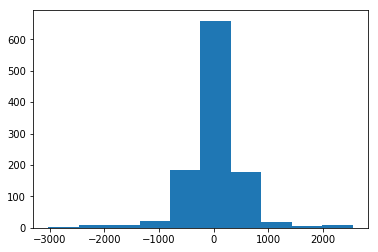

In [38]:
from scipy.stats import normaltest

resid = results.resid
print(normaltest(resid))
plt.hist(resid)
print(np.mean(resid))

### fb Prophet Analysis

In [93]:
prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
bart_pro = bart.rename(columns={'Date': 'ds', 'Riders': 'y'})
bart_pro = bart_pro.drop(columns = 'Hour')
prophet.fit(bart_pro);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Joseph\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,y
0,2016-01-01,988
1,2016-01-02,1363
2,2016-01-03,1057
3,2016-01-04,2612
4,2016-01-05,2755
5,2016-01-06,2867
6,2016-01-07,3113
7,2016-01-08,3148
8,2016-01-09,1634
9,2016-01-10,1271


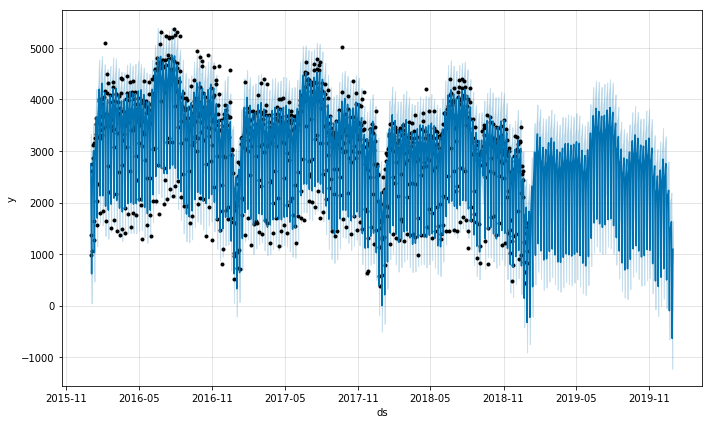

In [34]:
pd.plotting.register_matplotlib_converters()

# Create a future dataframe for 1 year
bart_forecast = prophet.make_future_dataframe(periods=365, freq='D')
# Make predictions
bart_forecast = prophet.predict(bart_forecast)
#print(bart_forecast)
fig = plt.figure()
fig.set_size_inches(16,6)
fig = prophet.plot(bart_forecast);

In [94]:
bart_forecast.yhat

0       2752.667910
1       1604.682429
2        616.234624
3       2035.998769
4       2476.539839
           ...     
1454    1626.596957
1455     417.676212
1456    -634.578079
1457     719.743300
1458    1094.475578
Name: yhat, Length: 1459, dtype: float64

RMSE for 'Last-Value Forecast': 861.5795724418742
RMSE for Sample Mean Forecast: 900.4834253206625
RMSE for FB Prophet Forecast: 448.3866184288826


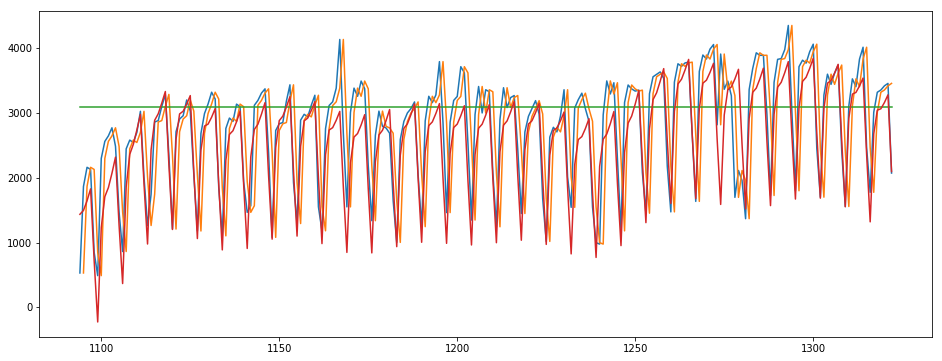

In [35]:
base_last_value = []
for i in range(len(test) - 1):
    base_last_value.append(test[i])
    
base_sample_mean = np.mean(series)
prophet_forecast = bart_forecast.yhat[len(series):len(series)+len(test)]

x_f = np.arange(len(series), len(series)+len(test))

fig = plt.figure(figsize=(16,6))
plt.plot(x_f, test)
plt.plot(x_f[1:], base_last_value)
plt.plot(x_f, np.ones(len(test)) * base_sample_mean)
plt.plot(x_f, prophet_forecast)

print("RMSE for 'Last-Value Forecast': {0}".format(rmse(test[1:], base_last_value)))
print("RMSE for Sample Mean Forecast: {0}".format(rmse(test, base_sample_mean)))
print("RMSE for FB Prophet Forecast: {0}".format(rmse(test, prophet_forecast)))

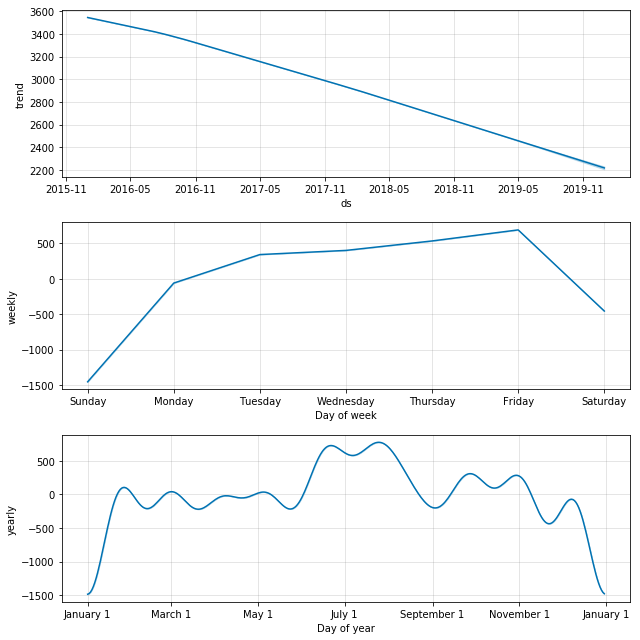

In [26]:
prophet.plot_components(bart_forecast);

### Forecasting using LSTMs

In [37]:
#scaler = MinMaxScaler(feature_range=(0,1))
#series_fit = scaler.fit(series.reshape(-1,1).astype('float32'))
#series_scaled = scaler.transform(series.reshape(-1,1).astype('float32'))
#test_scaled = scaler.transform(test.reshape(-1,1).astype('float32'))
series_scaled = ((series - np.min(series)) / (np.max(series) - np.min(series))).reshape(-1,1)
test_scaled = ((test - np.min(series)) / (np.max(series) - np.min(series))).reshape(-1,1)

In [32]:
def ts_lstm_format(ts, p):
    """
    Creates appropriate dataset form from the time series ts for input to LSTM: 
    target variable is the value at time t+1, and the features are the values of 
    the time series from t-p up to t.
    ts: np array
    p: positive integer
    """
    features, target = [], []
    for i in range(len(ts) - p - 1):
        features.append(ts[i:i+p, 0])
        target.append(ts[i+p, 0])
    features = np.reshape(features, (len(features), p, 1))
    return features, np.array(target)

In [72]:
p = 1
features, target = ts_lstm_format(series_scaled, p)

backend.set_epsilon(1)

lstm = Sequential()
lstm.add(LSTM(3, input_shape=(1, p)))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape'])
lstm.fit(features, target, epochs=3, batch_size=1)

Epoch 1/3
1092/1092 [==============================] - 7s 7ms/step - loss: 0.2233 - mean_absolute_percentage_error: 42.1183
Epoch 2/3
1092/1092 [==============================] - 4s 4ms/step - loss: 0.0613 - mean_absolute_percentage_error: 21.3671
Epoch 3/3
1092/1092 [==============================] - 4s 4ms/step - loss: 0.0413 - mean_absolute_percentage_error: 16.6407


296.50113911307074


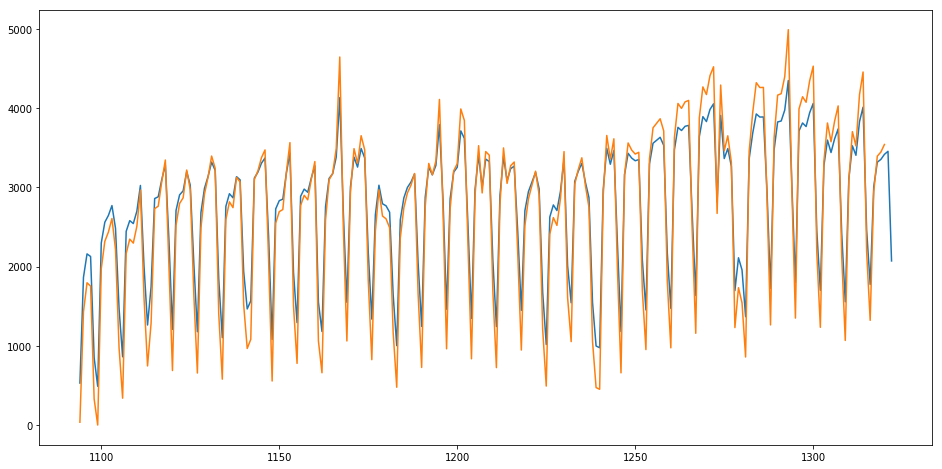

In [74]:
val_x, val_y = ts_lstm_format(test_scaled, 1)

forecast_train = lstm.predict(features)
forecast_train = (forecast_train - np.min(forecast_train)) / (np.max(forecast_train) - np.min(forecast_train))
forecast_train = forecast_train * (np.max(series) - np.min(series)) + np.min(forecast_train)

forecast_test = -lstm.predict(val_x)
forecast_test = (forecast_test - np.min(forecast_test)) / (np.max(forecast_test) - np.min(forecast_test))
forecast_test = forecast_test * (np.max(series) - np.min(series)) + np.min(forecast_train)

fig = plt.figure(figsize=(16,8))
#fig = plt.plot(forecast_train[1050:,0])
#plt.plot(series[1050:])
plt.plot(np.arange(len(series), len(series)+len(test)), test)
plt.plot(np.arange(len(series), len(series)+len(forecast_test)), forecast_test[:,0])
#plt.legend((#'Training Forecast', 'Training Set', 'Test Set', 'Test Set Forecast'))
print(rmse(test[:-2], forecast_test[:,0]))